In [17]:
import torch
import numpy as np
from PIL import Image
import segmentation_models_pytorch as smp
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [38]:
image_path = "/home/xinrong/huawei-rs/data/1024_1024/images/182_29_9.png"  
mask_path = "/home/xinrong/huawei-rs/data/1024_1024/labels/182_29_9.png"
checkpoint_path = "/home/xinrong/huawei-rs/checkpoints/unet_se_resnext101_32x4d/202011160946/epoch_0_0.7445.pth"

In [39]:
aux_params_dict = dict(pooling="avg", dropout=0.5, activation="softmax", classes=2)
model = smp.Unet(
        encoder_name="se_resnext101_32x4d",
        encoder_weights=None,
        classes=2,
        activation="sigmoid",
        decoder_attention_type="scse",
        decoder_use_batchnorm=True,
        aux_params=aux_params_dict)

In [40]:
checkpoint = torch.load(checkpoint_path)

state_dict = OrderedDict()
for key, value in checkpoint["state_dict"].items():
    tmp = key[7:]
    state_dict[tmp] = value
model.load_state_dict(state_dict)
model = model.to("cpu")
model.eval()

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [51]:
image = np.array(Image.open(image_path))
mask = np.array(Image.open(mask_path))

image = image/255
image = image.transpose(2,0,1)

image = image[np.newaxis, :, :, :].astype(np.float32)
image = torch.from_numpy(image)
image = Variable(image.to("cpu"))

In [53]:
from torch import Tensor

# TTA
def torch_rot90(x: Tensor):
    """
    Rotate 4D image tensor by 90 degrees
    :param x:
    :return:
    """
    return torch.rot90(x, k=1, dims=(2, 3))


def torch_rot180(x: Tensor):
    """
    Rotate 4D image tensor by 180 degrees
    :param x:
    :return:
    """
    return torch.rot90(x, k=2, dims=(2, 3))


def torch_rot270(x: Tensor):
    """
    Rotate 4D image tensor by 270 degrees
    :param x:
    :return:
    """
    return torch.rot90(x, k=3, dims=(2, 3))

def torch_transpose(x: Tensor):
    """
    Transpose 4D image tensor by main image diagonal
    :param x:
    :return:
    """
    return x.transpose(2, 3)

def torch_none(x: Tensor) -> Tensor:
    """
    Return input argument without any modifications
    :param x: input tensor
    :return: x
    """
    return x

def _inference(model, image, threshold=0.75):
    output, *_ = model(image)

    for aug, deaug in zip(
        [torch_rot90, torch_rot180, torch_rot270],
        [torch_rot270, torch_rot180, torch_rot90],
    ):
        tmp, *_ = model(aug(image))
        x = deaug(tmp)
        output += F.sigmoid(x)


    image = torch_transpose(image)

    for aug, deaug in zip(
        [torch_none, torch_rot90, torch_rot180, torch_rot270],
        [torch_none, torch_rot270, torch_rot180, torch_rot90],
    ):
        tmp, *_ = model(aug(image))
        # x = deaug(model(aug(image)))
        x = deaug(tmp)
        output += F.sigmoid(torch_transpose(x))

    one_over_8 = float(1.0 / 8.0)
    out_l_tta = output * one_over_8
    out_l_tta = out_l_tta.cpu().data.numpy()
    return (out_l_tta[0, 1, :, :] > threshold).astype(np.int8)

/home/xinrong/torch/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/xinrong/torch/lib64/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


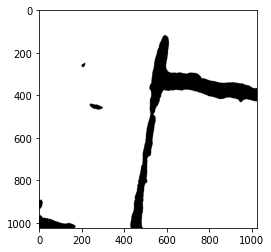

In [54]:
# tta
mask = _inference(model, image)
plt.imshow(mask, cmap="gray")

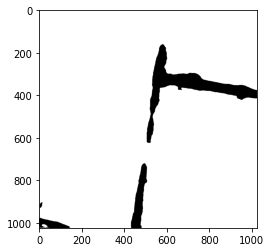

In [52]:
# without tta
out_l, *_ = model(image)
out_l = out_l.cpu().data.numpy()
out_l = np.argmax(out_l, axis=1)[0].astype(np.int8)

plt.imshow(out_l, cmap="gray")

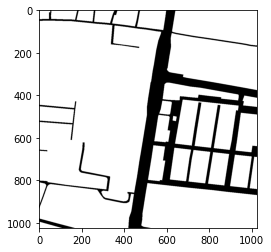

In [31]:
# gt 
plt.imshow(mask, cmap="gray")